# Case study: Farrell zebrafish embryo data

This notebook generates results for a case study that uses a [zebrafish embryo Drop-Seq dataset](https://singlecell.broadinstitute.org/single_cell/study/SCP162/single-cell-reconstruction-of-developmental-trajectories-during-zebrafish-embryogenesis).

We compare the embedding using a standard variational autoencoder (VAE), default ViVAE and a ViVAE encoder-only (parametric MDS-like) model.
To this end, we will plot encoder indicatrices for each model.

<hr>

## **0.** Load required modules

In addition to `ViVAE`, `ViScore` and their dependenceis, you will need to have `umap` and `SQuadMDS` installed in your conda environment.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import copy
import numpy as np
import pandas as pd
import scipy
from scipy.stats import rankdata
import colorsys
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from matplotlib import patches
import ViVAE
import ViScore
from sklearn.manifold import TSNE
import torch
from umap import UMAP
from SQuadMDS import SQuadMDS
from sklearn.manifold import TSNE
from matplotlib.patches import Rectangle

## **1.** Load input data

See the ViScore [benchmarking](https://github.com/saeyslab/ViScore/tree/main/benchmarking) page for instructions on how to obtain and pre-process the Farrell data.

In [2]:
## Load input data

pc   = np.load(os.path.join('..', 'data', 'Farrell_input.npy'),          allow_pickle=True)
pc_d = np.load(os.path.join('..', 'data', 'Farrell_input_denoised.npy'), allow_pickle=True)
labs = np.load(os.path.join('..', 'data', 'Farrell_labels.npy'),         allow_pickle=True)
knn  = np.load(os.path.join('..', 'data', 'Farrell_knn.npy'),          allow_pickle=True)

There is also metadata describing cell development that we will want to use in our exploration.

In [117]:
## Load metadata

meta        = pd.read_csv('../data/Farrell_meta.txt', sep='\t')                # this is the `URD_Dropseq_Meta.txt` file from Single Cell Portal
ps          = np.load('../data/Farrell_URD_pseudotime.npy', allow_pickle=True) # URD pseudotime values per cell
expr_nanos3 = np.load('../data/Farrell_exprs_NANOS3.npy', allow_pickle=True)   # expression values of NANOS3

The pseudotime values in `ps` were inferred by the authors using [URD](https://github.com/farrellja/URD), their supervised trajectory inference tool.
`ps`, as well as the expression values in `expr_nanos3` were extracted using R.
Specifically, we downloaded `URD_Zebrafish_Object.rds` from the Single Cell Portal and ran the following R script:

```R
library(URD)
library(reticulate)
np <- import('numpy')
x  <- readRDS('URD_Zebrafish_Object.rds')

## Extract pseudotime ----
ps <- x@tree$pseudotime
if (all(names(ps)==meta$NAME[-1])) message('Cell names are correctly aligned')
np$save('../data/Farrell_URD_pseudotime.npy', ps, allow_pickle = TRUE)

## Extract expression (scaled) ----
g <- 'NANOS3'
np$save(paste0('../data/Farrell_exprs_', g, '.npy'), exprs[g, , drop = TRUE], allow_pickle = TRUE)
```

<hr>

## **2.** Generate embeddings

We generate embeddings of this data, or load them from NumPy binaries if they have already been generated.

In [4]:
retrain = True # to be able to make indicatrices later

res_exist = np.sum([
        not os.path.exists(f'emb_Farrell_{m}.npy')
        for m in ['tsne', 'umap', 'squadmds', 'vae', 'vivae', 'vivae_enconly']
    ])==0

if not res_exist or retrain:
    print('Generating t-SNE embedding')
    emb_tsne = TSNE(n_components=2, random_state=42).fit_transform(pc)
    np.save('emb_Farrell_tsne.npy', emb_tsne, allow_pickle=True)

    print('Generating UMAP embedding')
    emb_umap = UMAP(n_components=2, random_state=42).fit_transform(pc)
    np.save('emb_Farrell_umap.npy', emb_umap, allow_pickle=True)

    print('Generating SQuad-MDS embedding')
    emb_squadmds = SQuadMDS(n_components=2, random_state=42).fit_transform(pc)
    np.save('emb_Farrell_squadmds.npy', emb_squadmds, allow_pickle=True)

    print('Generating VAE embedding')
    torch.manual_seed(42)
    np.random.seed(42)
    model_vae = ViVAE.ViVAE(input_dim=pc.shape[1], latent_dim=2, random_state=42)
    model_vae.fit(pc, lam_recon=1., lam_kldiv=1., lam_mds=0., verbose=False)
    emb_vae = model_vae.transform(pc)
    np.save('emb_Farrell_vae.npy', emb_vae, allow_pickle=True)

    print('Generating ViVAE embedding')
    torch.manual_seed(42)
    np.random.seed(42)
    model_vivae_enconly = ViVAE.ViVAE(input_dim=pc.shape[1], latent_dim=2, random_state=42)
    model_vivae_enconly.fit(pc_d, lam_recon=0., lam_kldiv=1., lam_mds=10., verbose=False)
    emb_vivae_enconly = model_vivae_enconly.transform(pc_d)
    np.save('emb_Farrell_vivae_enconly.npy', emb_vivae_enconly, allow_pickle=True)

    print('Generating ViVAE-EncoderOnly embedding')
    torch.manual_seed(42)
    np.random.seed(42)
    model_vivae = ViVAE.ViVAE(input_dim=pc.shape[1], latent_dim=2, random_state=42)
    model_vivae.fit(pc_d, lam_recon=1., lam_kldiv=1., lam_mds=100., verbose=False)
    emb_vivae = model_vivae.transform(pc_d)
    np.save('emb_Farrell_vivae.npy', emb_vivae, allow_pickle=True)
else:
    print('Loading embeddings')
    emb_tsne = np.load('emb_Farrell_tsne.npy', allow_pickle=True)
    emb_umap = np.load('emb_Farrell_umap.npy', allow_pickle=True)
    emb_squadmds = np.load('emb_Farrell_squadmds.npy', allow_pickle=True)
    emb_vae = np.load('emb_Farrell_vae.npy', allow_pickle=True)
    emb_vivae = np.load('emb_Farrell_vivae.npy', allow_pickle=True)
    emb_vivae_enconly = np.load('emb_Farrell_vivae_enconly.npy', allow_pickle=True)

Generating t-SNE embedding
Generating UMAP embedding
Generating SQuad-MDS embedding
Generating VAE embedding
Generating ViVAE embedding
Generating ViVAE-EncoderOnly embedding


## **3.** Plot embeddings with cells labelled by developmental stages

In [10]:
def rainbow(n, saturation=.5, brightness=.8):
  hsv = [(h, saturation, brightness) for h in np.linspace(0, 1, n)]
  rgb = [colorsys.hsv_to_rgb(*h) for h in hsv]
  hex = ['#%02x%02x%02x' % (int(r[0]*255), int(r[1]*255), int(r[2]*255)) for r in rgb]
  return np.array(hex)
palette = rainbow(len(np.unique(labs)))

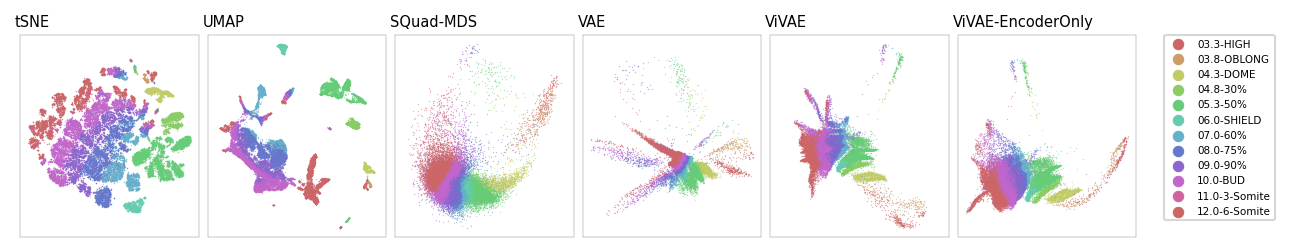

In [11]:
mpl.rcParams['axes.linewidth'] = 0.1
pops = np.unique(labs)
methods = ['tSNE', 'UMAP', 'SQuad-MDS', 'VAE', 'ViVAE', 'ViVAE-EncoderOnly']
nmet = len(methods)
fig, ax = plt.subplots(nrows=1, ncols=nmet, figsize=(1.6*nmet, 1.75), dpi=150)
fig.subplots_adjust(wspace=.05)
handles = []
labels = []
embs = [emb_tsne, emb_umap, emb_squadmds, emb_vae, emb_vivae, emb_vivae_enconly]
s = .01
for i, method in enumerate(methods):
    emb = embs[i]
    for j, pop in enumerate(pops):
        idcs = np.where(labs==pop)[0]
        if i==0:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, label=pop, c=palette[j], alpha=1., linewidth=.5)
        else:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, c=palette[j], alpha=1., linewidth=.5)
    #ax[i].tick_params(axis='both', labelsize=5)
    ax[i].tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax[i].axis('equal')
    ax[i].set_title(methods[i], size=7, ha='left', x=-.03, y=.98)
    if i==(len(methods)-1):
        l = fig.legend(bbox_to_anchor=(1., .9), fontsize=5, markerscale=50.)
fig.savefig('Farrell_stages.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig('Farrell_stages.svg', bbox_inches='tight', transparent=True)

## **4.** Inspect cell developmental lineages

The authors label distinct developmental lineages, which we can project onto the embeddings.
We want to labels points belonging to each lineage by ordering (ranks) of cells within that lineage, based on pseudotime values extracted from the authors' published analysis.
But we need to be careful: all cells from the *03.3-HIGH* embryological stage were assigned a pseudotime value of zero.
We reflect this in the ordering by assigning them all a rank of 0 as well.

<hr>

We start by computing and scaling the cell ranks per lineage.

In [145]:
all_lineages = [s.replace('Lineage_', '') for s in meta.columns[3:]]
cell_idcs = {}
cell_ranks = {}
cell_ranks_unscaled = {}
for lin in all_lineages:
    ## Indices of cells within lineage
    idcs = np.where([x in ['True', 'TRUE'] for x in meta[f'Lineage_{lin}'][1:]])[0]

    ## Pseudotime values and stage labels of cells within lineage
    lin_ps = ps[idcs]
    lin_labs = labs[idcs]

    ## Cell progress within lineage per cell
    order = np.argsort(lin_ps, kind='stable')
    idcs = idcs[order]
    progress = np.repeat(0., len(idcs))
    idcs_non_origin = np.where(lin_labs!='03.3-HIGH')[0] # assign 0 to 03.3-hpf stage
    progress[idcs_non_origin] = np.linspace(start=0, stop=1, num=len(idcs_non_origin)+1)[1:]

    cell_idcs[lin] = idcs
    cell_ranks[lin] = progress

For our results section, we plot a selection of 6 cell lineages in the embeddings.
We colour each point based on the cell ordering, except for points that have a higher rank value than 0.95, which are instead drawn in red.

In [147]:
lineages = ['Prechordal_Plate', 'Notochord', 'Telencephalon', 'Adaxial_Cells', 'EVL', 'Primordial_Germ_Cells']

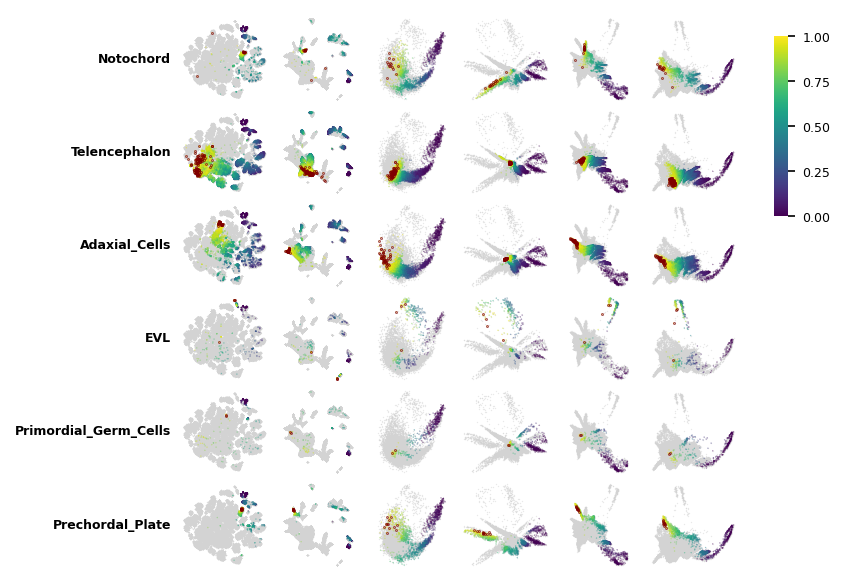

In [139]:
cols = ['Notochord', 'Telencephalon', 'Adaxial_Cells', 'EVL', 'Primordial_Germ_Cells', 'Prechordal_Plate']
methods = ['tSNE', 'UMAP', 'SQuad-MDS', 'VAE', 'ViVAE', 'ViVAE-EncoderOnly']
nmet = len(methods)
ncol = len(cols)
fig, ax = plt.subplots(nrows=ncol, ncols=nmet, figsize=(.8*nmet, .8*ncol), dpi=150)
fig.subplots_adjust(wspace=.05, hspace=.05)
embs = [emb_tsne, emb_umap, emb_squadmds, emb_vae, emb_vivae, emb_vivae_enconly]
mpl.rcParams['axes.linewidth'] = 0.
for i, col in enumerate(cols):
    
    idcs = cell_idcs[col]
    ranks = cell_ranks[col]

    idcs_terminal = np.where(ranks>.99)[0]

    nmet = len(methods)
    handles = []
    labels = []

    for j, method in enumerate(methods):
        emb = embs[j]
        ax[i][j].scatter(emb[:,0], emb[:,1], s=.01, c='lightgrey', linewidth=.5)
        ax[i][j].scatter(emb[idcs,0], emb[idcs,1], s=.01, c=ranks, linewidth=.5, cmap='viridis')
        ax[i][j].scatter(emb[idcs[idcs_terminal],0], emb[idcs[idcs_terminal],1], s=.08, edgecolors='face', c='maroon', linewidth=1.)
        ax[i][j].tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax[i][j].axis('equal')
        for spine in ax[i][j].spines.values():
            spine.set_edgecolor('none')
        if i==0 and j==(len(methods)-1):
            sm = mpl.cm.ScalarMappable(cmap='viridis')
            sm.set_array([0.,1.])
            cax = plt.axes([0.95, 0.6, 0.02, 0.25])
            cb = plt.colorbar(sm, cax=cax, location='right')
            for t in cb.ax.get_yticklabels():
                t.set_fontsize(6)

for a, row in zip(ax[:,0], cols):
    a.annotate(row, xy=(0, .5), xytext=(0, 0), xycoords=a.yaxis.label, textcoords='offset points', size=6, weight='bold', ha='right', va='center')

#fig.suptitle('B', x=0.03, y=.91, size=12, weight='bold')
fig.savefig('Farrell_lineages.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig('Farrell_lineages.svg', bbox_inches='tight', transparent=True)

## **5.** Evaluate faithfulness of lineage embeddings

We also evaluate how faithfully the transitions along a specific lineage are represented.
The pseudotime ordering, by definition, positions the cells along a developmental continuum.
Each transition from one cell to another is associated with a distance (L2 norm) between the two cells (or cell embeddings).

Transition distances between consecutive cells quantify the rate at which the trajectory traverses each part of the point cloud, until it reaches a terminus.
We take the cumulative sum of the transition distances and normalise them to sum to 1, so as to account for differences in scale between input data and embeddings.

Since we have the ground truth (cumulative transitions in the input space), we want to measure how close our embeddings are to this.
To measure the dissimilarity of these transitions from the ground truth, we compute Earth mover's distances.

<hr>

We first make a full plot for all annotated lineages.
Then we make a plot where we show the transitions for one lineage (prechordal plate) as a demonstration and a summary plot with scores for all lineages.

<hr>

We start by defining a function to compute the transitions and EMDs per lineage per method.

In [164]:
def compute_transitions(repre_names, repre_data, lineages, #ps, meta,
                        cell_idcs=cell_idcs):

    names = repre_names
    data = repre_data

    all_td = {} # cumulative transition distances (TDs)
    all_wd = {} # Wasserstein distances from ground-truth TDs
    all_which_best = {} # indices of best performer per lineage

    for lin in lineages:
        ## Get pseudotime-ordered indices of cells in this lineage
        idcs = cell_idcs[lin]

        ## Compute transition distances
        td = {}
        for name, dat in zip(names, data):
            ## Calculate distances
            lin_dist = []
            for i in range(len(idcs)-1):
                j = i+1
                d = np.linalg.norm(dat[idcs[j]]-dat[idcs[i]])
                lin_dist.append(d)
            lin_dist = np.array(lin_dist)
            cum_dist = np.cumsum(lin_dist)
            td[name] = cum_dist/np.max(cum_dist)

        ## Compute Earth Mover's Distances
        wd = {}
        wd['Input space'] = 0.
        which_best = names[0]
        best = np.inf
        for name in names:
            if name!='Input space':
                res = scipy.stats.wasserstein_distance(td['Input space'], td[name])
                wd[name] = res
                if res<best:
                    best = res
                    which_best = name

        all_td[lin] = td
        all_wd[lin] = wd
        all_which_best[lin] = which_best
    
    return all_td, all_wd, all_which_best

Next, we define a method to plot the transitions, along with the EMDs displayed.

In [171]:
def plot_transitions(all_td, all_wd, all_which_best, repre_names, lineages, labs,
                     #meta, ps,
                     fname=None, legend=True, legend_position=(.98, .8845), label_lineages=True,
                     cell_idcs=cell_idcs, cell_ranks=cell_ranks
                     ):
    names = repre_names

    ## Init figure
    fig, ax = plt.subplots(nrows=len(lineages), ncols=len(names), figsize=(len(names)*3, len(lineages)*3), dpi=150)
    fig.subplots_adjust(wspace=.1, hspace=.15)

    for l,lin in enumerate(lineages):

        ## Get sorted indices
        idcs = cell_idcs[lin]

        ## Get cell progress
        progress = cell_ranks[lin]

        ## Get labelled stage per cell (target vertices only, hence index 0 omitted)
        stages = labs[idcs][1:]

        ## Extract computed results
        td = all_td[lin]
        wd = all_wd[lin]
        which_best = all_which_best[lin]

        ## Plot cumulative transitions and EMDs
        for i, repre in enumerate(names):
            aa = ax[l][i] if len(lineages)>1 else ax[i]
            for j, pop in enumerate(pops):
                pop_idcs = np.where(stages==pop)[0]
                for c in [.2,.4,.6,.8]:
                    aa.axhline(y=c, linestyle='--', linewidth=.5, c='lightgrey', zorder=0)
                if l==0 and i==0:
                    aa.scatter(progress[1:][pop_idcs], td[repre][pop_idcs], s=.3, c=palette[j], label=pop)
                else:
                    aa.scatter(progress[1:][pop_idcs], td[repre][pop_idcs], s=.3, c=palette[j])
            if l==0:
                aa.set_title(repre, fontstyle='italic' if i==0 else 'normal')
            if i==0:
                aa.set_yticks([0.,.2,.4,.6,.8,1.], labels=['0','.2','.4','.6','.8','1'])
            else:
                aa.set_yticks([0.,.2,.4,.6,.8,1.], labels=[])
                aa.set_xticks([.5, 1.], labels=['.5', '1'])
                #str_emd = f'Sim={(1-wd[repre]):.3f}'
                str_emd = f'EMD={("%.4f"%wd[repre]).lstrip("0")}'
                aa.text(0.,.95, str_emd, weight='bold' if repre==which_best else 'light')

            if l==int(np.ceil(len(lineages)/2)-1) and i==0:
                aa.set_ylabel('Cumulative transitions')
            
            if i==int(np.ceil(len(names)/2)-1) and l==len(lineages)-1:
                aa.set_xlabel('Rank')
            if legend:
                if i==(len(names)-1) and l==0:
                    _ = fig.legend(bbox_to_anchor=legend_position, fontsize=10, markerscale=15.)

    if label_lineages:
        if len(lineages)>1:
            for a, row in zip(ax[:0], lineages):
                a.annotate(row, xy=(-1.8, .5), xytext=(0, 0), xycoords=a.yaxis.label, textcoords='offset points', size=12, weight='bold', ha='right', va='center')
        else:
            ax[0].annotate(lineages[0], xy=(-1.8, .5), xytext=(0, 0), xycoords=ax[0].yaxis.label, textcoords='offset points', size=12, weight='bold', ha='right', va='center')

    if fname is not None:
        fig.savefig(f'{fname}.png', bbox_inches='tight', dpi=600, transparent=True)
        fig.savefig(f'{fname}.svg', bbox_inches='tight', transparent=True)
    
    return fig,ax

We compute the transitions and make the plot for all lineages.

In [172]:
all_lineages = [s.replace('Lineage_', '') for s in meta.columns[3:]]

repre_names = ['Input space', 't-SNE', 'UMAP', 'SQuad-MDS', 'VAE', 'ViVAE', 'ViVAE-EncoderOnly']
repre_data  = [pc, emb_tsne, emb_umap, emb_squadmds, emb_vae, emb_vivae, emb_vivae_enconly]

td, wd, which_best = compute_transitions(repre_names=repre_names, repre_data=repre_data, lineages=all_lineages)#, ps=ps, meta=meta)

In [174]:
%%capture
_ = plot_transitions(
    all_td=td,
    all_wd=wd,
    all_which_best=which_best,
    repre_names=['Input space', 't-SNE', 'UMAP', 'SQuad-MDS', 'VAE', 'ViVAE', 'ViVAE-EncoderOnly'],
    lineages=all_lineages,
    labs=labs,
    fname='Farrell_transitions_full'
)

Next, we create the figure for only the prechordal plate lineage, which is there to illustrate the methodology and show that the embeddings differ in how dense they make the different cell populations.

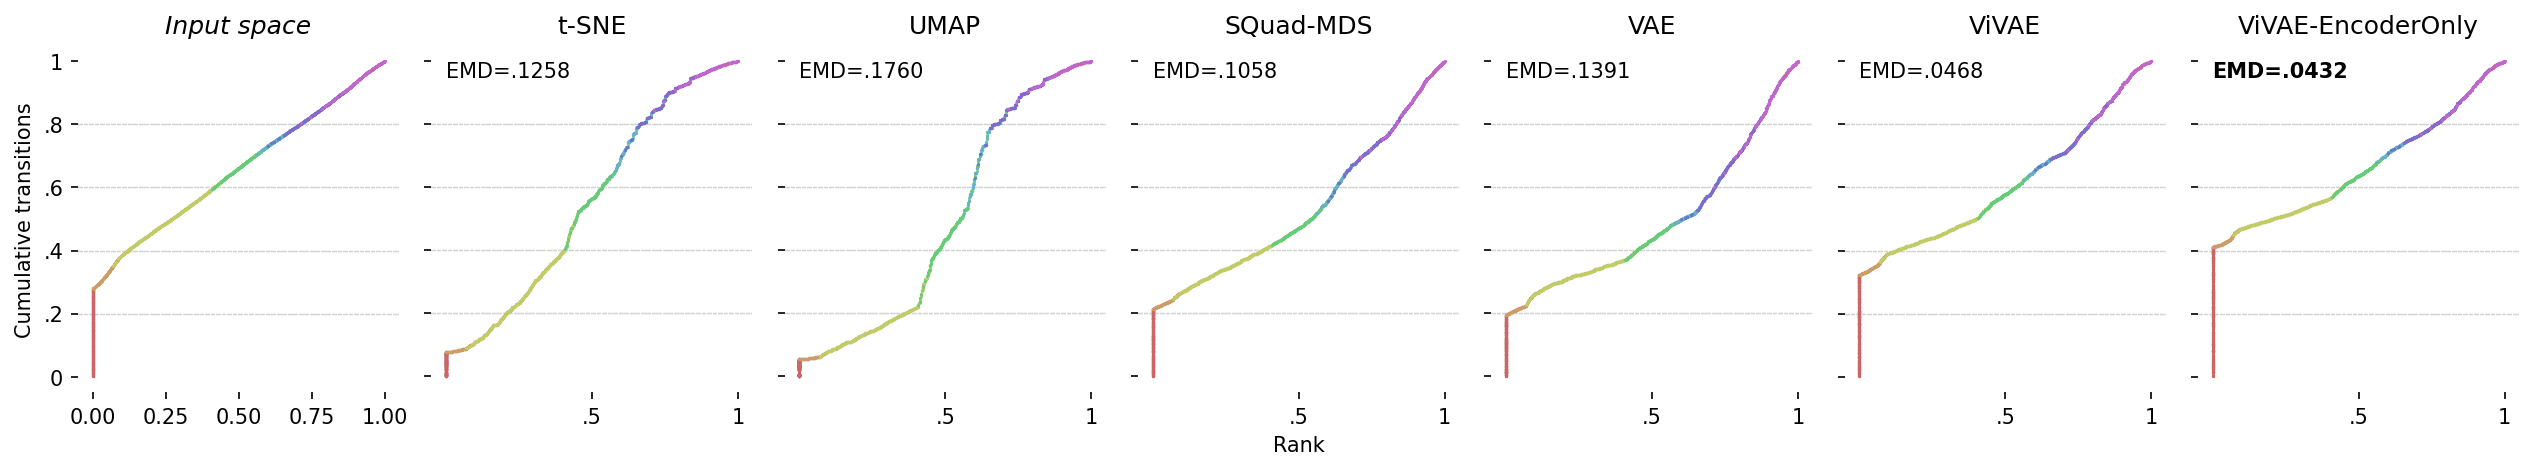

In [173]:
fig, ax = plot_transitions(
    all_td={'Prechordal_Plate': td['Prechordal_Plate']},
    all_wd={'Prechordal_Plate': wd['Prechordal_Plate']},
    all_which_best={'Prechordal_Plate': which_best['Prechordal_Plate']},
    repre_names=['Input space', 't-SNE', 'UMAP', 'SQuad-MDS', 'VAE', 'ViVAE', 'ViVAE-EncoderOnly'],
    lineages=['Prechordal_Plate'],
    #meta=meta,
    labs=labs,
    #ps=ps,
    label_lineages=False,
    legend=False,
    #legend_position=(.98, .904)
    fname='Farrell_transitions_prechordal'
)

To give a comprehensive overview, we compute the results per lineage per embedding for all annotated lineages, and plot in a heatmap.

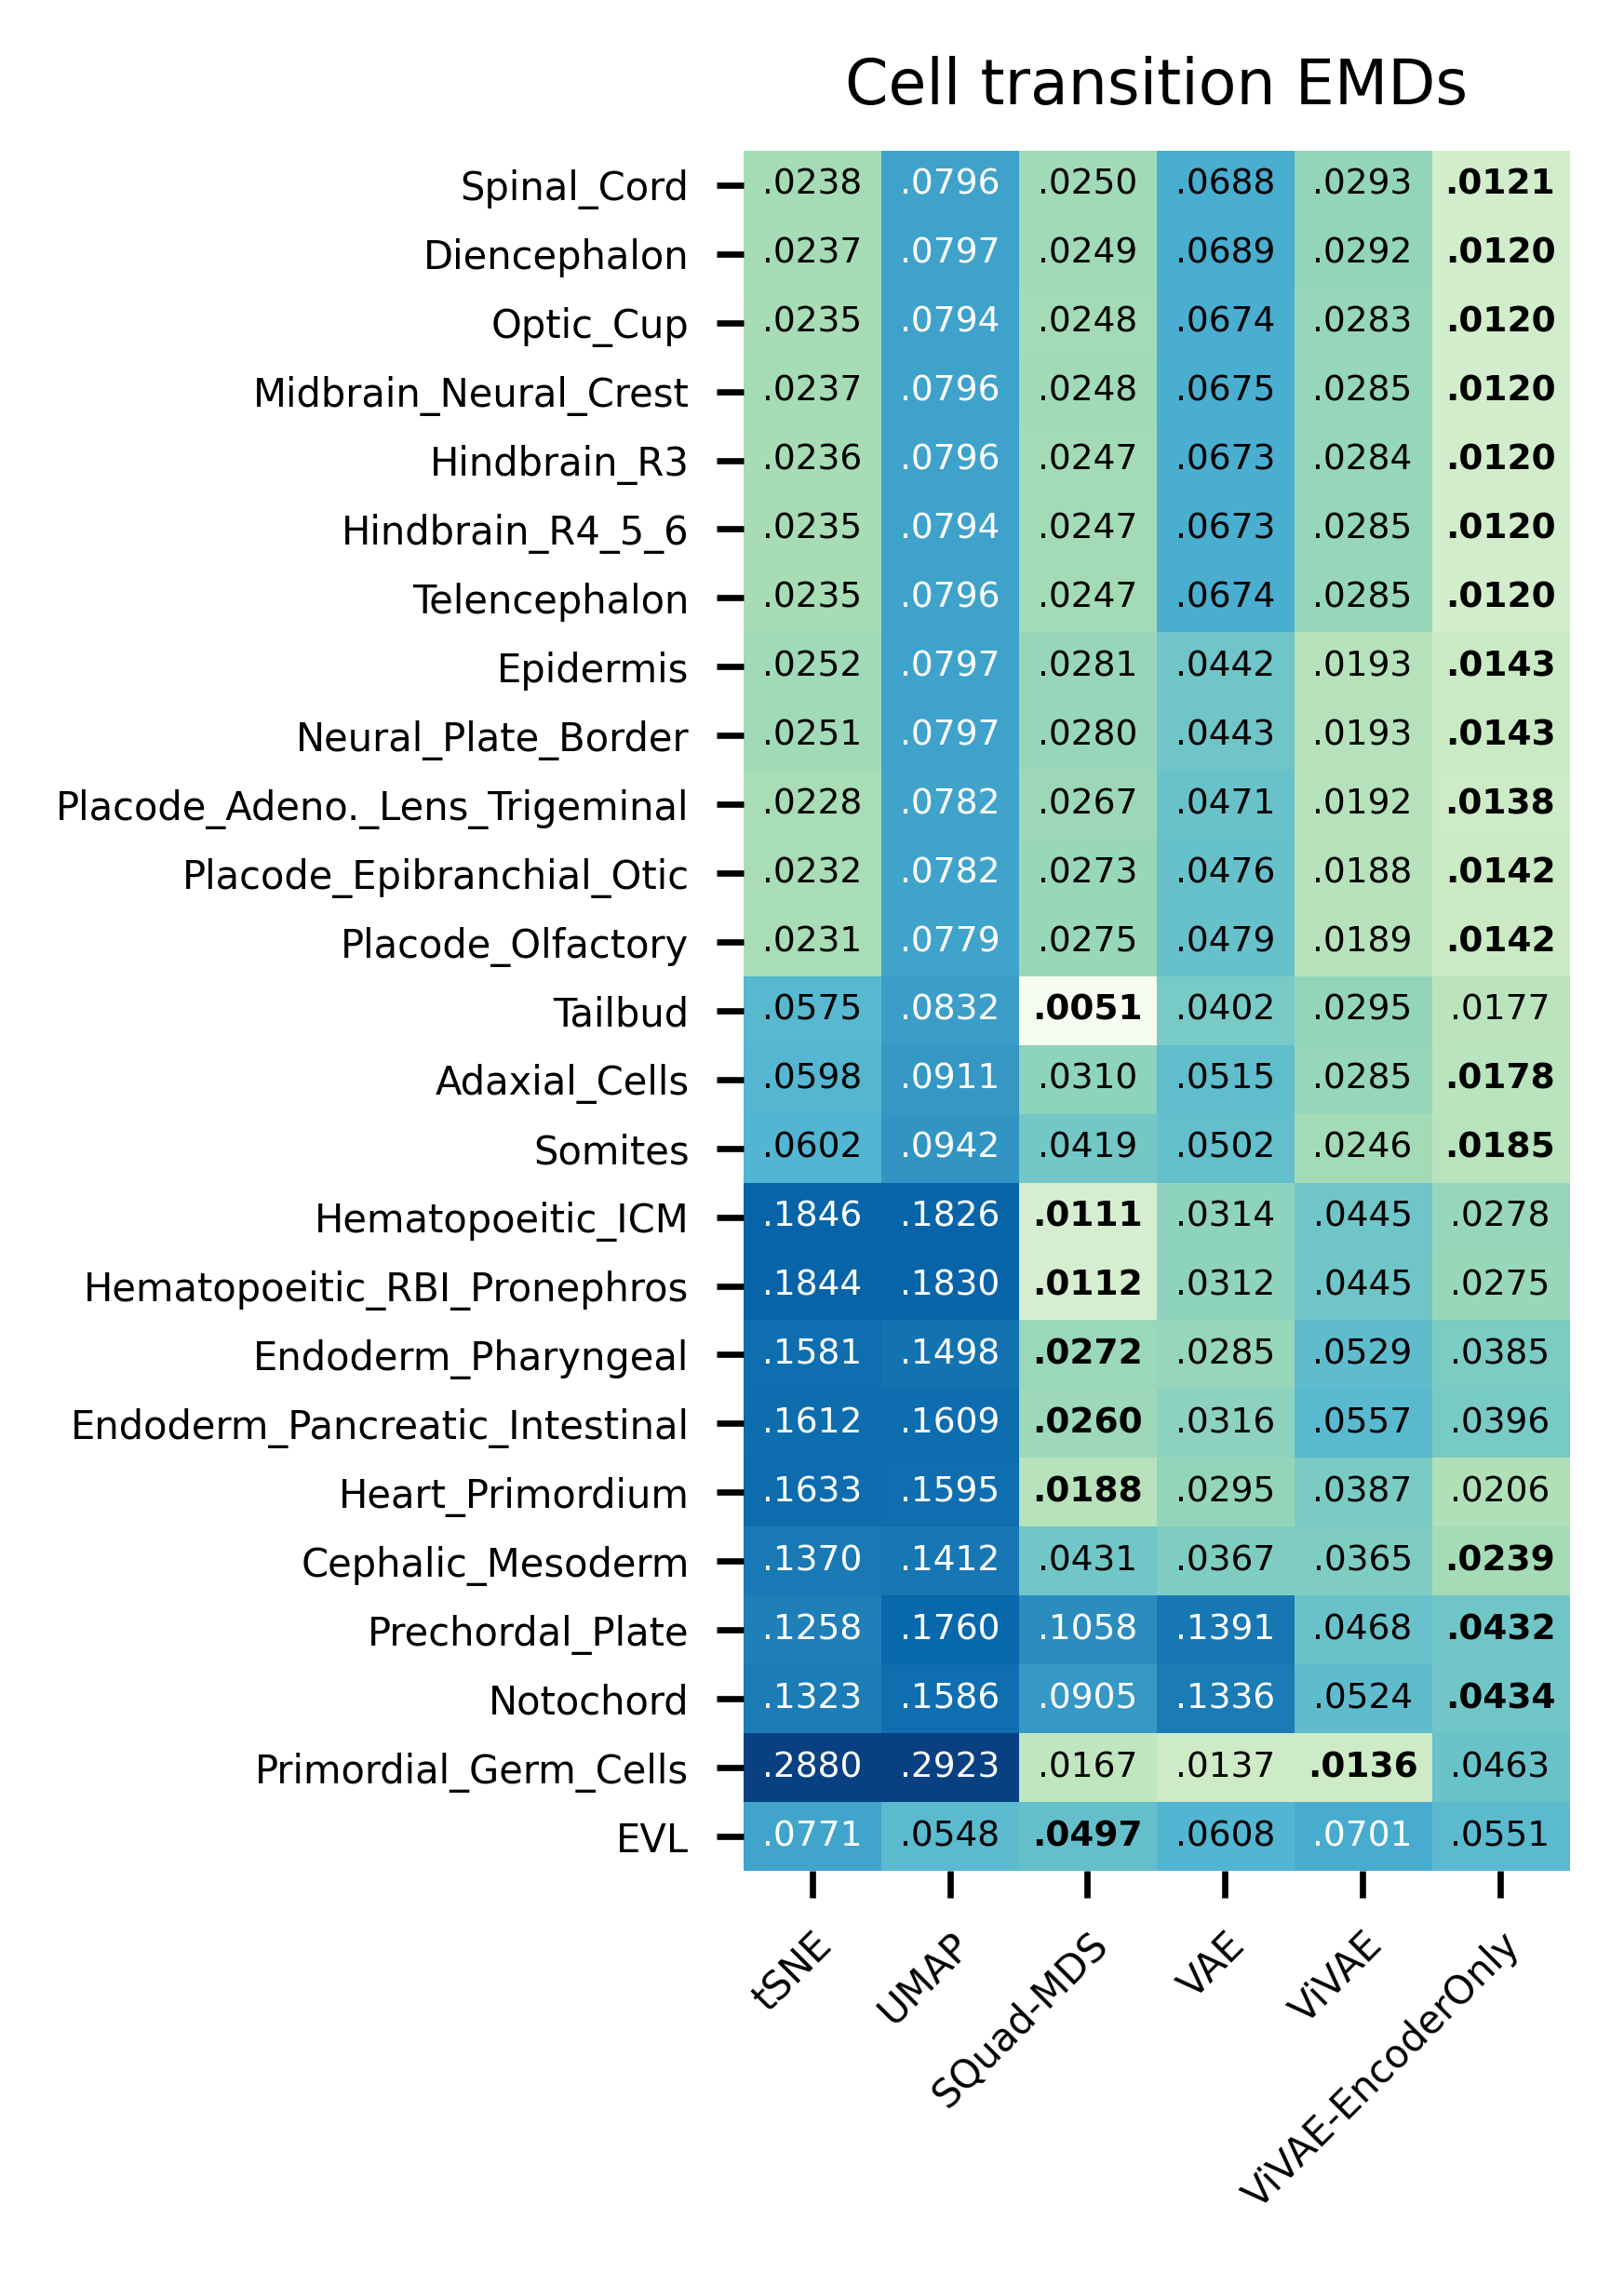

In [175]:
## Store results in a matrix for plotting the heatmap

wd_matrix = np.array([list(wd[lin].values())[1:] for lin in all_lineages])

## Compute number of cells in each lineage (for figure)

ls = [len(np.where([x in ['True', 'TRUE'] for x in meta[f'Lineage_{lin}'][1:]])[0]) for lin in all_lineages]

## Plot heatmap of results per lineage per embedding

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=600)

im = ax.imshow(np.log(wd_matrix), cmap='GnBu', aspect=.5)
ax.set_yticks(np.arange(len(all_lineages)), labels=all_lineages, size=5)
ax.set_xticks(np.arange(len(methods)), labels=methods, size=5)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

for i in range(len(all_lineages)):
    vals = wd_matrix[i,:]
    which_best = np.argmin(vals)
    for j in range(len(methods)):
        val = vals[j]
        color = 'black' if val<.07 else 'white'
        weight = 'bold' if j==which_best else 'normal'
        str_emd = ('%.4f'%val).lstrip('0')
        text = ax.text(j, i, str_emd, ha='center', va='center', color=color, weight=weight, size=4.5)
ax.set_title('Cell transition EMDs', size=8)

fig.savefig(f'Farrell_emds_heatmap.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig(f'Farrell_emds_heatmap.svg', bbox_inches='tight', transparent=True)
#plt.close()

## **5.** Compute and plot encoder indicatrices for VAE-based models

We also use this case study to demonstrate the analysis of latent space distortions using encoder indicatrices.
First, we compute indicatrices for the entire embedding from each VAE-based model and plot them.

Next, we zoom in to inspect parts of the latent space where notable distortion is detected and re-compute indicatrices on a higher-resolution grid to analyse these specific sections of the embeddings.

The parameters used for computing and plotting the indicatrices, as well as coordinates for zooming in assume that PyTorch keeps things reproducible. 
If not, you will probably not need to adjust the indicatrix parameters, but you may well need to make adjustments to the coordinates due to some instability (eg. rotation of the embeddings).

<hr>

First let's compute the indicatrices.

In [18]:
ei_vae           = model_vae.encoder_indicatrices(X=pc, radius=1e-1, n_steps=28, n_polygon=500)
ei_vivae         = model_vivae.encoder_indicatrices(X=pc_d, radius=5e-1, n_steps=17, n_polygon=500)
ei_vivae_enconly = model_vivae_enconly.encoder_indicatrices(X=pc_d, radius=1e-1, n_steps=25, n_polygon=500)
# try and reflect difference in scales across embeddings in the `n_steps`
# !!! what matters is the shape distortion (ellipses) and the inconsistence in size of indicatrices--not the absolute sizes

Now we can plot the full embeddings with indicatrices superimposed (and check whether they're parametrised decently).

In [ ]:
mpl.rcParams['axes.linewidth'] = 0.1
pops = np.unique(labs)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3), dpi=600)
emb = emb_vivae

## Scale factors: how big the indicatrices should be plotted

sfs = [2e1, 3e0, 1e1]

## Inset specs: VAE and ViVAE each get a list of (1) coordinates of bottom-left corner of rectangle and (2) width and height of rectangle
## To be able to check the coordinates, comment out the line: `ax[i].tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)`

vae_cutout   = [(-7,-3), (5,5)]
#vivae_cutout = [(-1.5, 2), (4,4)]
vivae_cutout = [(4, -2), (4,4)]

for i, method in enumerate(methods):
    si = subset_idcs[i]
    s = 2.
    if si is None:
        s = .01
        si = np.arange(len(labs))
    emb = embs[i]
    ei = eis[i]
    sf = sfs[i]
    for j, pop in enumerate(pops):
        idcs = np.where(labs[si]==pop)[0]
        if i==0:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, label=pop, c=palette[j], alpha=1., linewidth=.5)
        else:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, c=palette[j], alpha=1., linewidth=.5)

    if method=='VAE':
        rect = Rectangle(xy=vae_cutout[0], width=vae_cutout[1][0], height=vae_cutout[1][1], ls='dashed', lw=1, edgecolor='black', facecolor='none', zorder=1)
        ax[i].add_patch(rect)
    if method=='ViVAE':
        rect = Rectangle(xy=vivae_cutout[0], width=vivae_cutout[1][0], height=vivae_cutout[1][1], ls='dashed', lw=1, edgecolor='black', facecolor='none', zorder=1)
        ax[i].add_patch(rect)

    pol = ei.get_polygons(scale_factor=sf)
    pol.set_color([0 / 255, 0 / 255, 0 / 255, 0.15])
    pol.set_linewidth(.2)
    pol.set_edgecolor('black')
    ax[i].add_collection(pol)

    ax[i].tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax[i].axis('equal')
    
#fig.suptitle('C', x=0.03, y=.91, size=12, weight='bold')
fig.savefig('Farrell_indicatrices_zoomout.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig('Farrell_indicatrices_zoomout.svg', bbox_inches='tight', transparent=True)

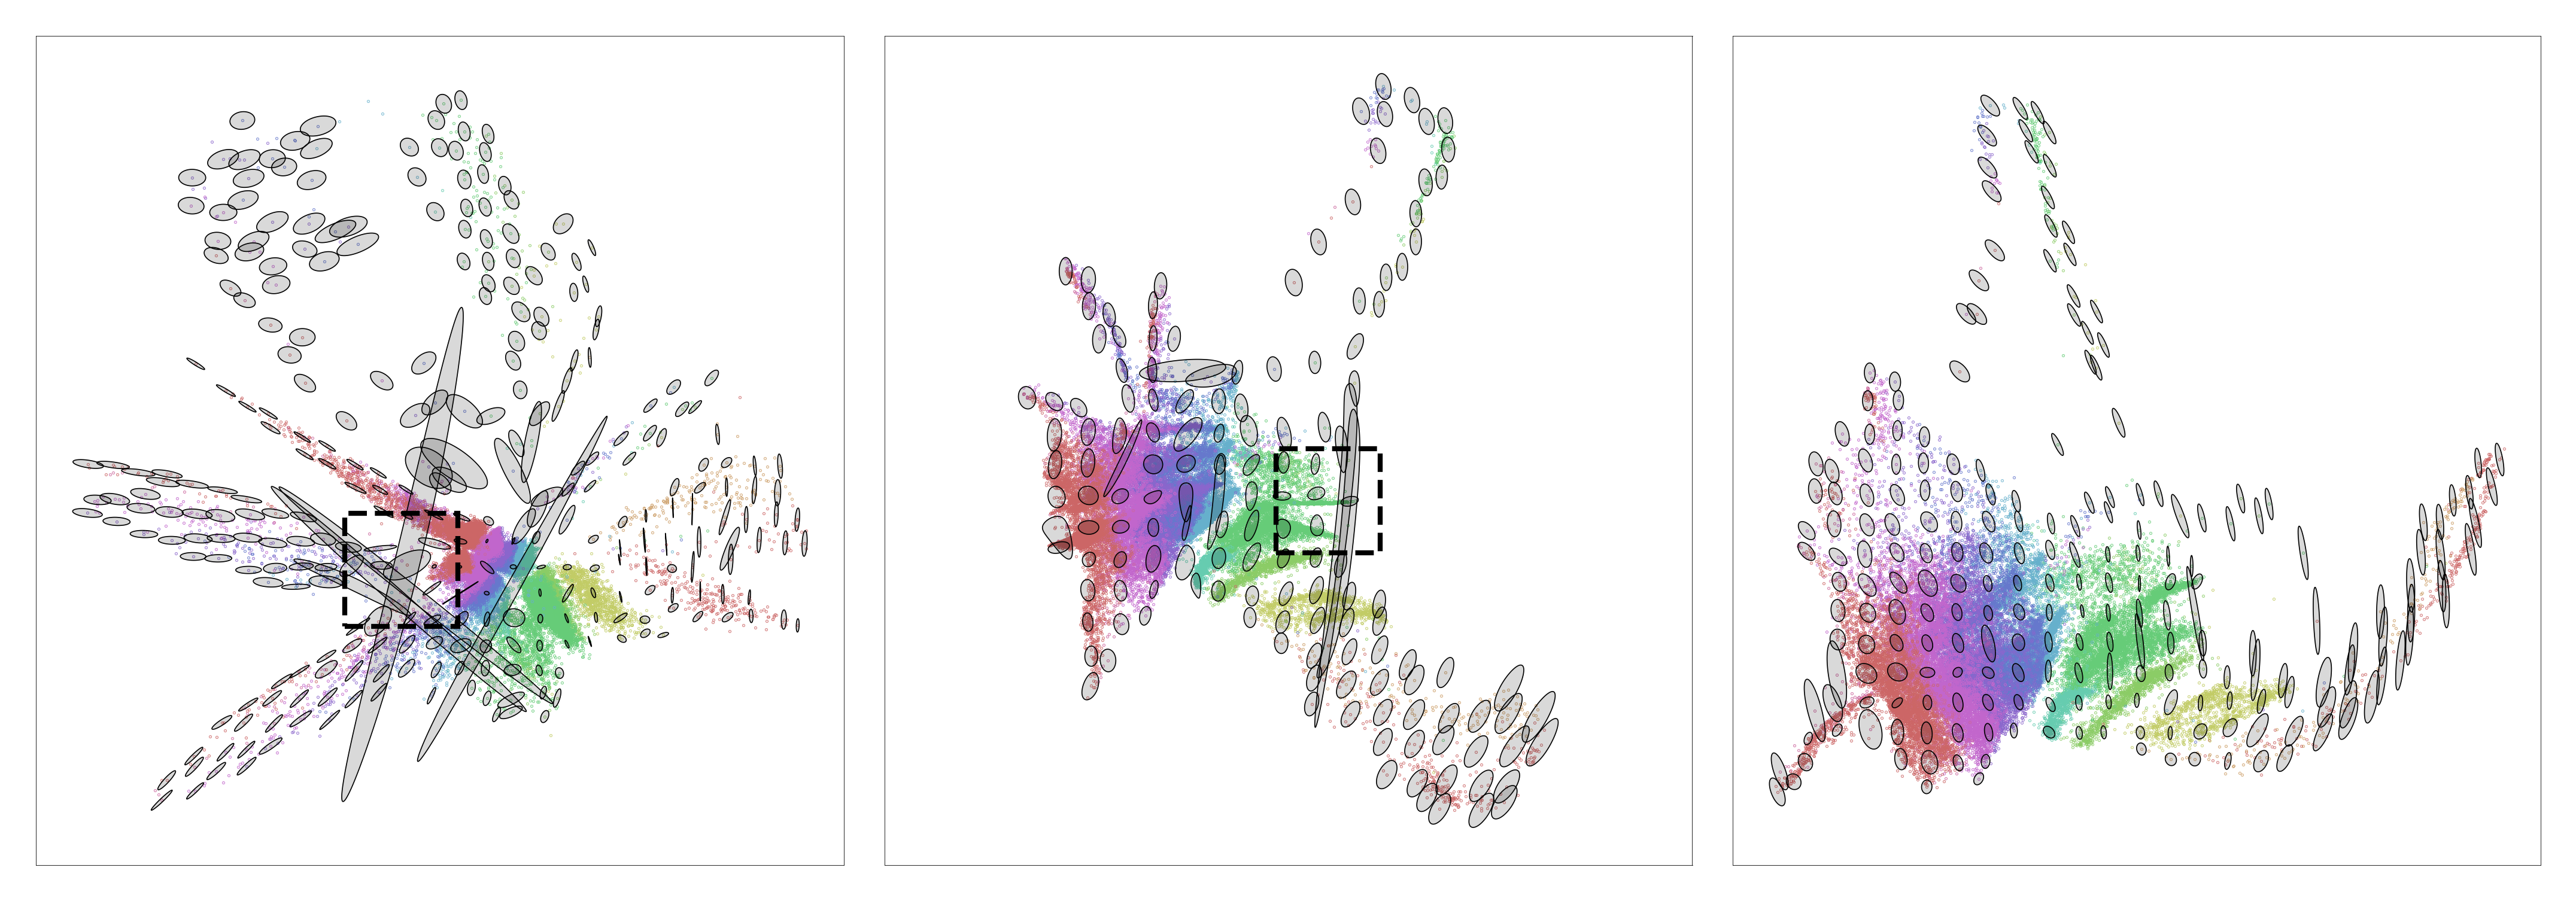

In [35]:
mpl.rcParams['axes.linewidth'] = 0.1
pops = np.unique(labs)
methods = ['VAE', 'ViVAE', 'ViVAE-EncoderOnly']
nmet = len(methods)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3), dpi=600)
fig.subplots_adjust(hspace=.05, wspace=.05)
handles = []
labels = []
methods = ['VAE', 'ViVAE', 'ViVAE-EncoderOnly']
embs = [emb_vae, emb_vivae, emb_vivae_enconly]
eis = [ei_vae, ei_vivae, ei_vivae_enconly]
subset_idcs = [None, None, None]

## Scale factors: how big the indicatrices should be plotted

sfs = [2e1, 3e0, 1e1]

## Inset specs: VAE and ViVAE each get a list of (1) coordinates of bottom-left corner of rectangle and (2) width and height of rectangle
## To be able to check the coordinates, comment out the line: `ax[i].tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)`

vae_cutout   = [(-7,-3), (5,5)]
#vivae_cutout = [(-1.5, 2), (4,4)]
vivae_cutout = [(3.5, -2), (4,4)]

for i, method in enumerate(methods):
    si = subset_idcs[i]
    s = 2.
    if si is None:
        s = .01
        si = np.arange(len(labs))
    emb = embs[i]
    ei = eis[i]
    sf = sfs[i]
    for j, pop in enumerate(pops):
        idcs = np.where(labs[si]==pop)[0]
        if i==0:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, label=pop, c=palette[j], alpha=1., linewidth=.5)
        else:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, c=palette[j], alpha=1., linewidth=.5)

    if method=='VAE':
        rect = Rectangle(xy=vae_cutout[0], width=vae_cutout[1][0], height=vae_cutout[1][1], ls='dashed', lw=1, edgecolor='black', facecolor='none', zorder=1)
        ax[i].add_patch(rect)
    if method=='ViVAE':
        rect = Rectangle(xy=vivae_cutout[0], width=vivae_cutout[1][0], height=vivae_cutout[1][1], ls='dashed', lw=1, edgecolor='black', facecolor='none', zorder=1)
        ax[i].add_patch(rect)

    pol = ei.get_polygons(scale_factor=sf)
    pol.set_color([0 / 255, 0 / 255, 0 / 255, 0.15])
    pol.set_linewidth(.2)
    pol.set_edgecolor('black')
    ax[i].add_collection(pol)

    ax[i].tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax[i].axis('equal')
    
#fig.suptitle('C', x=0.03, y=.91, size=12, weight='bold')
fig.savefig('Farrell_indicatrices_zoomout.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig('Farrell_indicatrices_zoomout.svg', bbox_inches='tight', transparent=True)

Next, we isolate the zoomed-in parts for VAE and ViVAE, re-compute indicatrices for them and make the plots for them.

In [36]:
## Get inset indices

idcs_vae_zoom = np.bitwise_and(
        np.bitwise_and(emb_vae[:,0]>= vae_cutout[0][0],                   emb_vae[:,1]>=vae_cutout[0][1]),
        np.bitwise_and(emb_vae[:,0]<=(vae_cutout[0][0]+vae_cutout[1][0]), emb_vae[:,1]<=vae_cutout[0][1]+vae_cutout[1][1])
    )
idcs_vivae_zoom = np.bitwise_and(
        np.bitwise_and(emb_vivae[:,0]>= vivae_cutout[0][0],                     emb_vivae[:,1]>=vivae_cutout[0][1]),
        np.bitwise_and(emb_vivae[:,0]<=(vivae_cutout[0][0]+vivae_cutout[1][0]), emb_vivae[:,1]<=vivae_cutout[0][1]+vivae_cutout[1][1])
    )

## Compute correspondent indicatrices

#ei_vae_zoom   = model_vae.encoder_indicatrices(X=pc[idcs_vae_zoom], radius=1e-1, n_steps=28, n_polygon=500)
#ei_vivae_zoom = model_vivae.encoder_indicatrices(X=pc_d[idcs_vivae_zoom], radius=5e-1, n_steps=19, n_polygon=500)
ei_vae_zoom   = model_vae.encoder_indicatrices(X=pc[idcs_vae_zoom], radius=5e-2, n_steps=28, n_polygon=500)
ei_vivae_zoom = model_vivae.encoder_indicatrices(X=pc_d[idcs_vivae_zoom], radius=1e-1, n_steps=19, n_polygon=500)

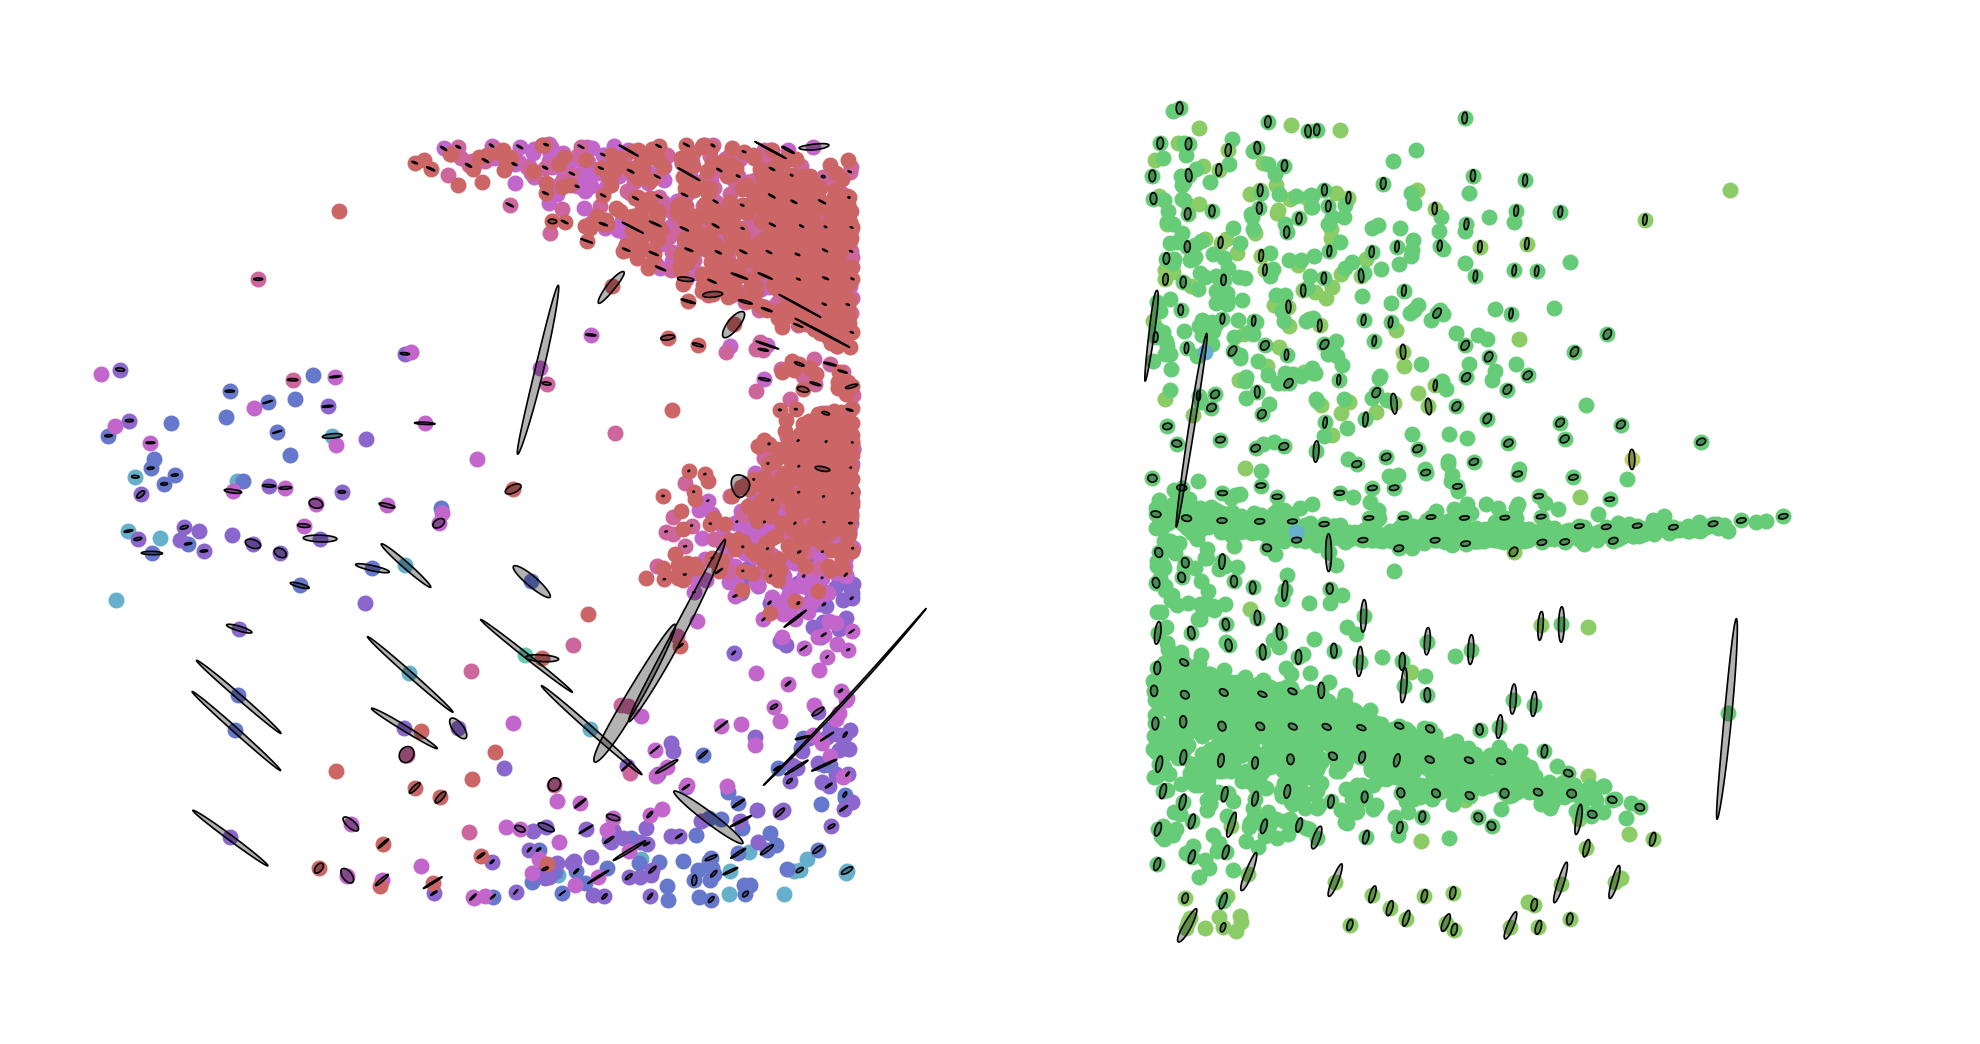

In [37]:
mpl.rcParams['axes.linewidth'] = 0.1
pops = np.unique(labs)
methods = ['VAE', 'ViVAE', 'ViVAE-EncoderOnly']
nmet = len(methods)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 2), dpi=600)
fig.subplots_adjust(hspace=.05, wspace=.05)
methods = ['VAE', 'ViVAE']
embs = [emb_vae[idcs_vae_zoom], emb_vivae[idcs_vivae_zoom]]
eis  = [ei_vae_zoom, ei_vivae_zoom]
ll   = [np.array(labs)[idcs_vae_zoom], np.array(labs)[idcs_vivae_zoom]]

## Scale factors: how big the indicatrices should be plotted

sfs = [2e0, 1e0]

for i, method in enumerate(methods):
    s = 2.
    emb = embs[i]
    ei = eis[i]
    sf = sfs[i]
    this_ll = ll[i]
    for j, pop in enumerate(pops):
        idcs = np.where(this_ll==pop)[0]
        if i==0:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, label=pop, c=palette[j], alpha=1., linewidth=.5)
        else:
            ax[i].scatter(emb[idcs,0], emb[idcs,1], s=s, c=palette[j], alpha=1., linewidth=.5)

    pol = ei.get_polygons(scale_factor=sf)
    pol.set_color([0 / 255, 0 / 255, 0 / 255, 0.3])
    
    pol.set_linewidth(.2)
    pol.set_edgecolor('black')

    ax[i].add_collection(pol)

    ax[i].tick_params(axis='both', labelsize=5)
    ax[i].tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax[i].axis('equal')
    ax[i].axis('off')
    
#fig.suptitle('C', x=0.03, y=.91, size=12, weight='bold')
fig.savefig('Farrell_indicatrices_zoomin.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig('Farrell_indicatrices_zoomin.svg', bbox_inches='tight', transparent=True)

<hr>

Additionally, we create some illustrative plots that we use in making an overview figure for how indicatrices are computed.
The first plot shows a grid of points sampled from the embedding to find indicatrices for their counterparts in the input space.
The second plot are the resulting indicatrices.

In [22]:
radius = 1e-1
n_steps = 12
n_polygon = 500
scale_factor = 12e0

## Compute gridpoint indices
ref = torch.Tensor(emb_vivae)
xmin, xmax = torch.min(ref[:,0]).item(), torch.max(ref[:,0]).item()
ymin, ymax = torch.min(ref[:,1]).item(), torch.max(ref[:,1]).item()
nsteps_x = n_steps
nsteps_y = math.ceil((ymax-ymin)/(xmax-xmin)*nsteps_x)
stepsize_x = (xmax-xmin)/(nsteps_x)
stepsize_y = (ymax-ymin)/(nsteps_y)
stepsize = min(stepsize_x, stepsize_y)
xs = torch.linspace(xmin, xmax, steps=nsteps_x)
ys = torch.linspace(ymin, ymax, steps=nsteps_y)
g_idcs = ViVAE.geometry.EncoderIndicatome.gridpoint_idcs(ref=ref, xgrid=xs, ygrid=ys)

## Trace back to ambient space
xr = torch.Tensor(pc_d[g_idcs])
zr = model_vivae.net.submersion(xr)

## Compute Jacobians
jac = torch.func.vmap(torch.func.jacfwd(model_vivae.net.submersion), in_dims=(0,))(xr)

## Find horizontal tangents
_, _, v = torch.svd(jac, some=False)
htv = v[:, :2]

## Create indicatrices in ambient space
xp = []
for i in range(xr.shape[0]):
    origin = xr[i]
    t1 = htv[i,0,:] # horizontal tangent vector 1
    t2 = htv[i,1,:] # horizontal tangent vector 1
    circle = ViVAE.geometry.EncoderIndicatome.circle_on_2manifold(origin, t1, t2, radius, n_polygon)
    xp.append(circle)

## Submerge indicatrices
zp = [model_vivae.net.submersion(this_xp) for this_xp in xp]

In [23]:
zp_scaled = []
for i in range(zr.shape[0]):
    res = ViVAE.geometry.EncoderIndicatome.scale_ellipse(zp[i], zr[i], scale_factor, False)
    zp_scaled.append(res)
polygons = [Polygon(tuple(vec.tolist()), closed=True) for vec in zp_scaled]
pol = PatchCollection(polygons)

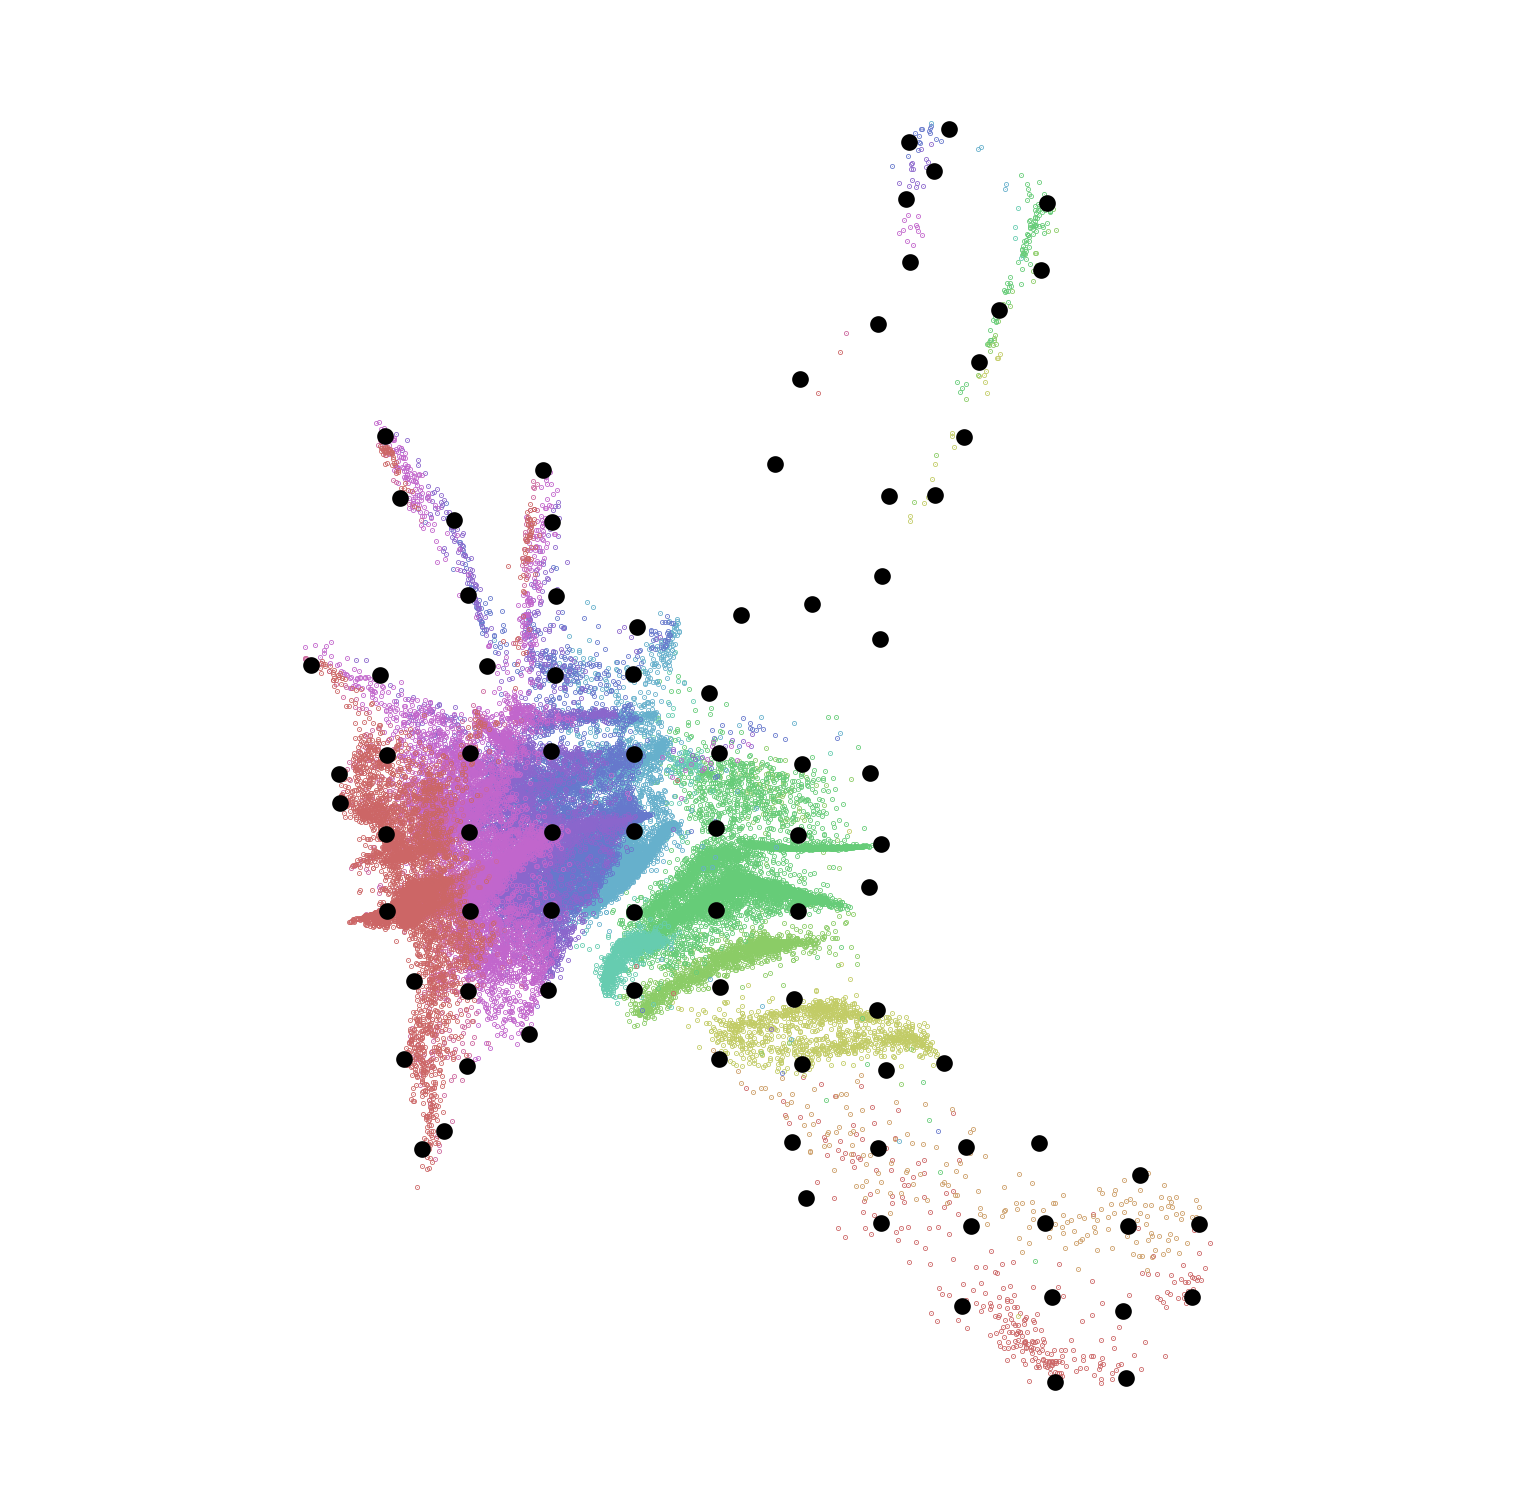

In [26]:
fig, ax = plt.subplots(figsize=(3,3), dpi=600)
for j, pop in enumerate(pops):
    idcs = np.where(labs==pop)[0]
    if i==0:
        ax.scatter(emb_vivae[idcs,0], emb_vivae[idcs,1], s=.01, label=pop, c=palette[j], alpha=1., linewidth=.5)
    else:
        ax.scatter(emb_vivae[idcs,0], emb_vivae[idcs,1], s=.01, c=palette[j], alpha=1., linewidth=.5)
ax.scatter(emb_vivae[g_idcs,0], emb_vivae[g_idcs,1], s=1., label=pop, c='black', alpha=1., linewidth=1.)
ax.tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
ax.axis('equal')
fig.savefig(f'Farrell_schematic_1.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig(f'Farrell_schematic_1.svg', bbox_inches='tight', transparent=True)

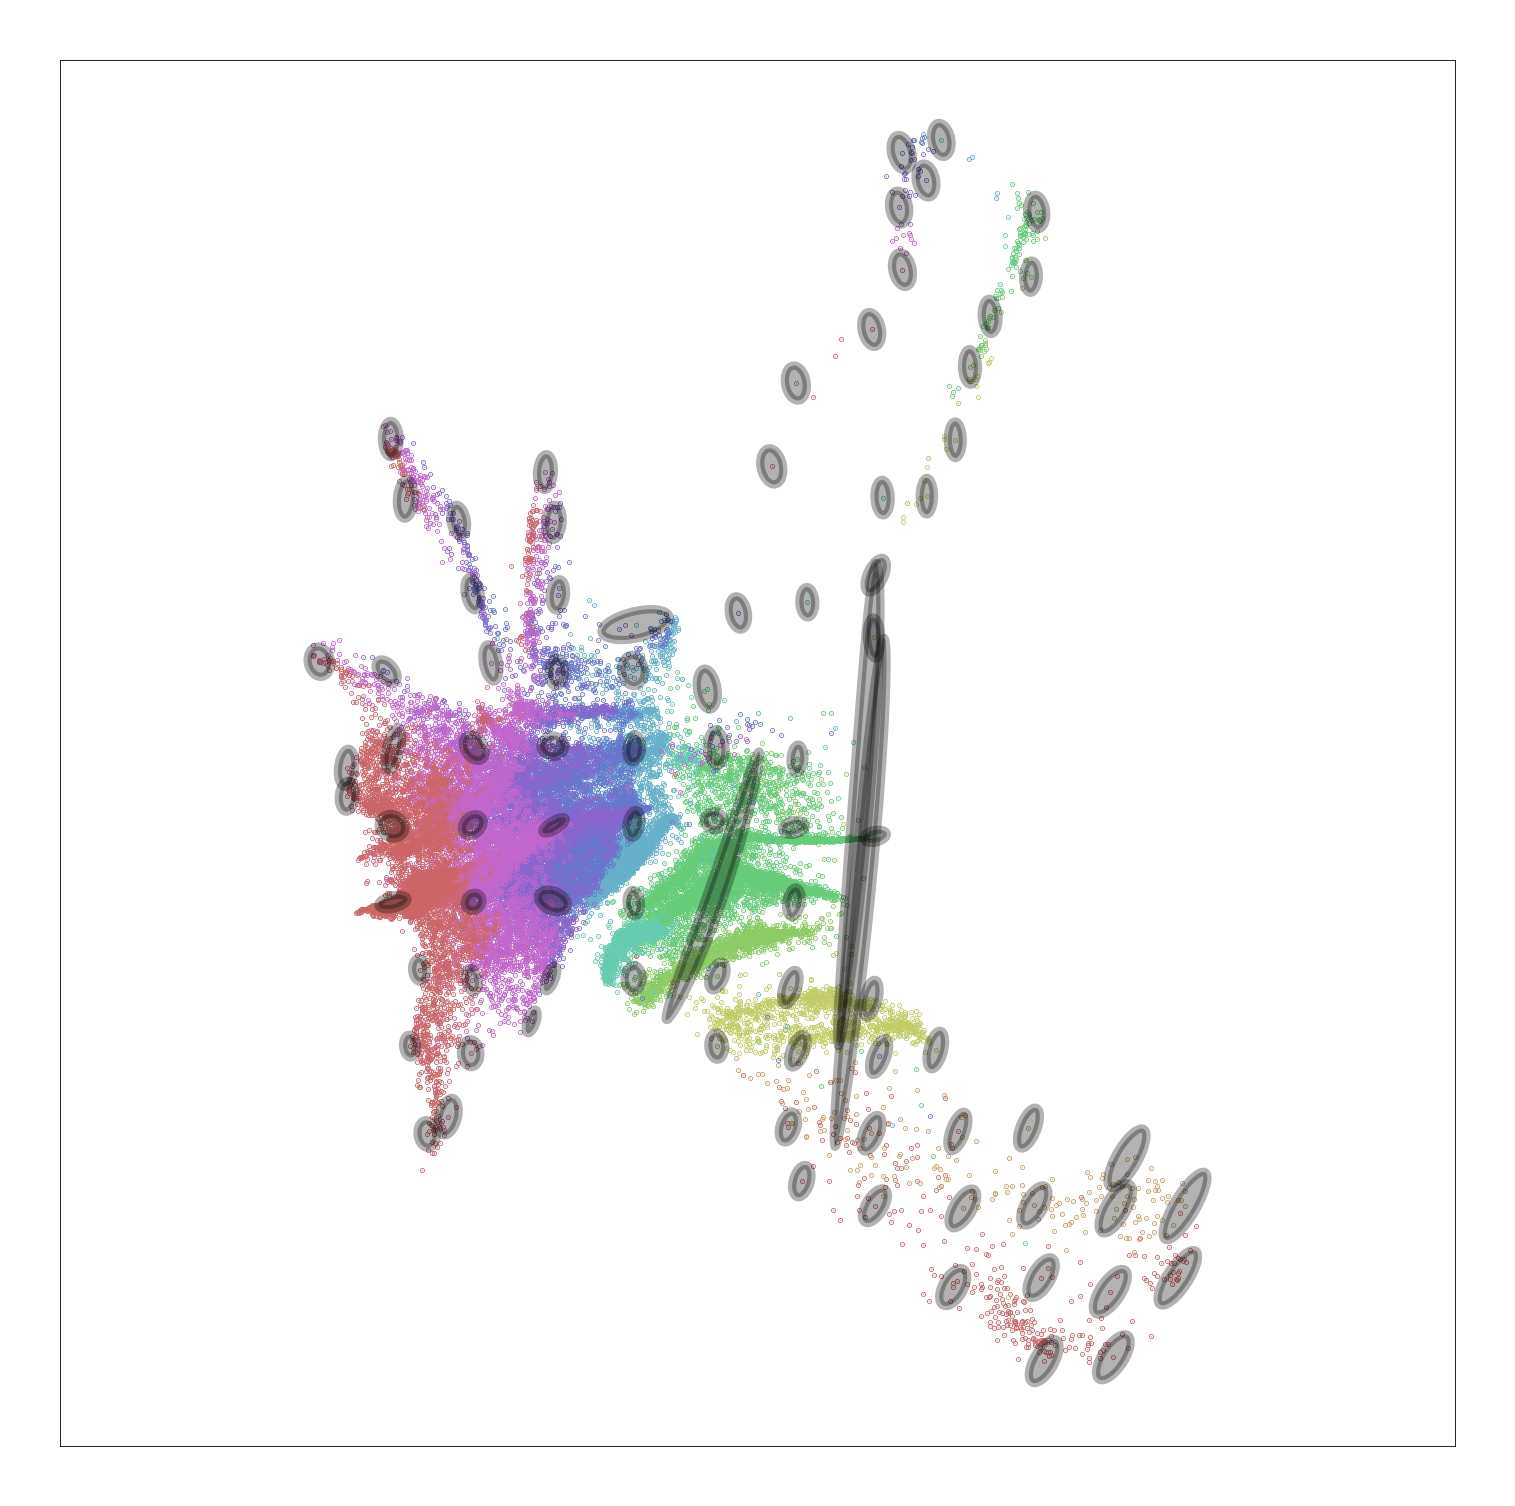

In [33]:
fig, ax = plt.subplots(figsize=(3,3), dpi=600)
pol = PatchCollection(polygons)
pol.set_color([0 / 255, 0 / 255, 0 / 255, 0.3])
for j, pop in enumerate(pops):
    idcs = np.where(labs==pop)[0]
    if i==0:
        ax.scatter(emb_vivae[idcs,0], emb_vivae[idcs,1], s=.01, label=pop, c=palette[j], alpha=1., linewidth=.5)
    else:
        ax.scatter(emb_vivae[idcs,0], emb_vivae[idcs,1], s=.01, c=palette[j], alpha=1., linewidth=.5)
#rect = Rectangle(xy=vivae_cutout[0], width=vivae_cutout[1][0], height=vivae_cutout[1][1], ls='dashed', lw=1, edgecolor='black', facecolor='none', zorder=1)
#ax.add_patch(rect)
ax.add_collection(pol)
ax.tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
ax.axis('equal')
fig.savefig(f'Farrell_schematic_2.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig(f'Farrell_schematic_2.svg', bbox_inches='tight', transparent=True)

## **7.** Compute xNPE for the *06.0-SHIELD* stage

This is to specifically validate the difference in position *06.0-SHIELD* of cells in the smoother (*SQuad-MDS* and VAE-based) embeddings, since it is notably different.

In [280]:
res_exist = np.sum([
        not os.path.exists(f'xnpe_{m}.npy')
        for m in ['tsne', 'umap', 'squadmds', 'vae', 'vivae', 'vivae_enconly']
    ])==0

if not res_exist:
    ## Compute xNPE

    xnpe_tsne          = ViScore.xnpe(hd=pc, ld=emb_tsne, annot=labs, knn=knn,          random_state=1)
    xnpe_umap          = ViScore.xnpe(hd=pc, ld=emb_umap, annot=labs, knn=knn,          random_state=1)
    xnpe_squadmds      = ViScore.xnpe(hd=pc, ld=emb_squadmds, annot=labs, knn=knn,      random_state=1)
    xnpe_vae           = ViScore.xnpe(hd=pc, ld=emb_vae,      annot=labs, knn=knn,      random_state=1)
    xnpe_vivae         = ViScore.xnpe(hd=pc, ld=emb_vivae, annot=labs, knn=knn,         random_state=1)
    xnpe_vivae_enconly = ViScore.xnpe(hd=pc, ld=emb_vivae_enconly, annot=labs, knn=knn, random_state=1)

    ## Save xNPE results

    np.save('xnpe_tsne.npy', xnpe_tsne, allow_pickle=True)
    np.save('xnpe_umap.npy', xnpe_umap, allow_pickle=True)
    np.save('xnpe_squadmds.npy', xnpe_squadmds, allow_pickle=True)
    np.save('xnpe_vae.npy', xnpe_vae, allow_pickle=True)
    np.save('xnpe_vivae.npy', xnpe_vivae, allow_pickle=True)
    np.save('xnpe_vivae_enconly.npy', xnpe_vivae_enconly, allow_pickle=True)
else:
    xnpe_tsne          = np.load('xnpe_tsne.npy', allow_pickle=True).item()
    xnpe_umap          = np.load('xnpe_umap.npy', allow_pickle=True).item()
    xnpe_squadmds      = np.load('xnpe_squadmds.npy', allow_pickle=True).item()
    xnpe_vae           = np.load('xnpe_vae.npy', allow_pickle=True).item()
    xnpe_vivae         = np.load('xnpe_vivae.npy', allow_pickle=True).item()
    xnpe_vivae_enconly = np.load('xnpe_vivae_enconly.npy', allow_pickle=True).item()

In [283]:
poi = '06.0-SHIELD' # population of interest
digits = 3

print(f"""xNPE of {poi}
    t-SNE:         {xnpe_tsne[poi]:.{digits}f}
    UMAP:          {xnpe_umap[poi]:.{digits}f}
    SQuad-MDS:     {xnpe_squadmds[poi]:.{digits}f}
    VAE:           {xnpe_vae[poi]:.{digits}f}
    ViVAE:         {xnpe_vivae[poi]:.{digits}f}
    ViVAE-EncOnly: {xnpe_vivae_enconly[poi]:.{digits}f}
""")

xNPE of 06.0-SHIELD
    t-SNE:         0.781
    UMAP:          0.858
    SQuad-MDS:     0.620
    VAE:           0.243
    ViVAE:         0.242
    ViVAE-EncOnly: 0.176



## **8.** Additional stuff...

We look at the expression of *NANOS3* as a marker for one of the two branches of primordial germ cells that we can see in our embedding...

Text(0.5, 1.0, 'Expression of NANOS3 in Primordial_Germ_Cells')

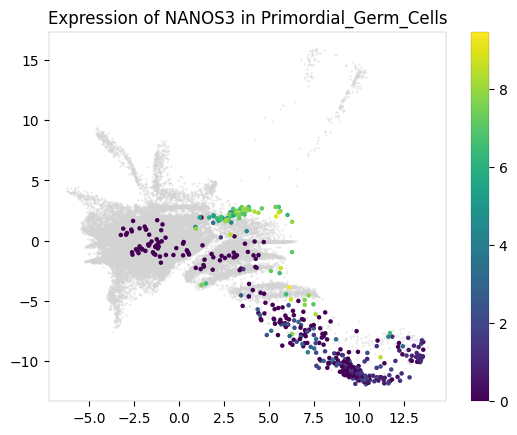

In [200]:
emb = emb_vivae
lin = 'Primordial_Germ_Cells'
gene = 'NANOS3'
e = np.load(f'./Farrell_exprs_{gene}.npy', allow_pickle=True)
lin_idcs = cell_idcs[lin]
plt.scatter(emb[:,0], emb[:,1], s=.1, c='lightgrey')
plt.scatter(emb[lin_idcs,0], emb[lin_idcs,1], s=5., c=e[lin_idcs])
plt.colorbar()
plt.title(f'Expression of {gene} in {lin}')
#plt.title('NANOS3 (functional) expression in PGCs')